    This is the jupyter notebook used for plotting surface seismograms (wiggles)
    and stress-strain curves of nonlinear soil in the 2D hypothetical basin model of Oral et al. (2019) 
    https://doi.org/10.1093/gji/ggz041

# 1) Import libraries
* Modify the path to JUPYTER

In [1]:
%matplotlib notebook

import sys
sys.path.append('/Users/elifo/Work/SOFT/sem2dpack/JUPYTER/')
sys.path.append('/Users/elifo/Work/SOFT/sem2dpack/JUPYTER/modules/')
from Class_sem2dpack import *

# 2) Input data
* Directory with output files
* Stress model (is_overburden): Depth-dependent (T) or Constant stress (F)

In [2]:
# Directory name with output files
direct1 = '../../EXAMPLES/SiteEffects/Oraletal2019_2Dbasin_PSV_nonlinear//'

is_overburden = True
fmin, fmax = 0.01, 10.0

# 3) Read output files

In [3]:
%%time 
SEM = sem2dpack(direct1)
# read seismograms
SEM.read_seismo(component='x')
# filter
SEM.filter_seismo(fmax=fmax, ftype='lowpass')
SEM.filter_seismo(fmin=fmin, ftype='highpass')
print ('*')

Reading grid information...
Reading header file...
0.00039999999 12501 817
Extra station number:  915
*
Filtering seissmograms ...
Filtering seissmograms ...
*
CPU times: user 1.74 s, sys: 113 ms, total: 1.85 s
Wall time: 2.03 s


# 4) Quick check of stations/receivers

In [4]:
# Seismogram coordinates are stored in SEM.rcoord
XSTA, ZSTA = SEM.rcoord[:,0], SEM.rcoord[:,1]
# SEM.time, SEM.velocity.shape
# min(XSTA), max(XSTA), min(ZSTA), max(ZSTA)

<IPython.core.display.Javascript object>


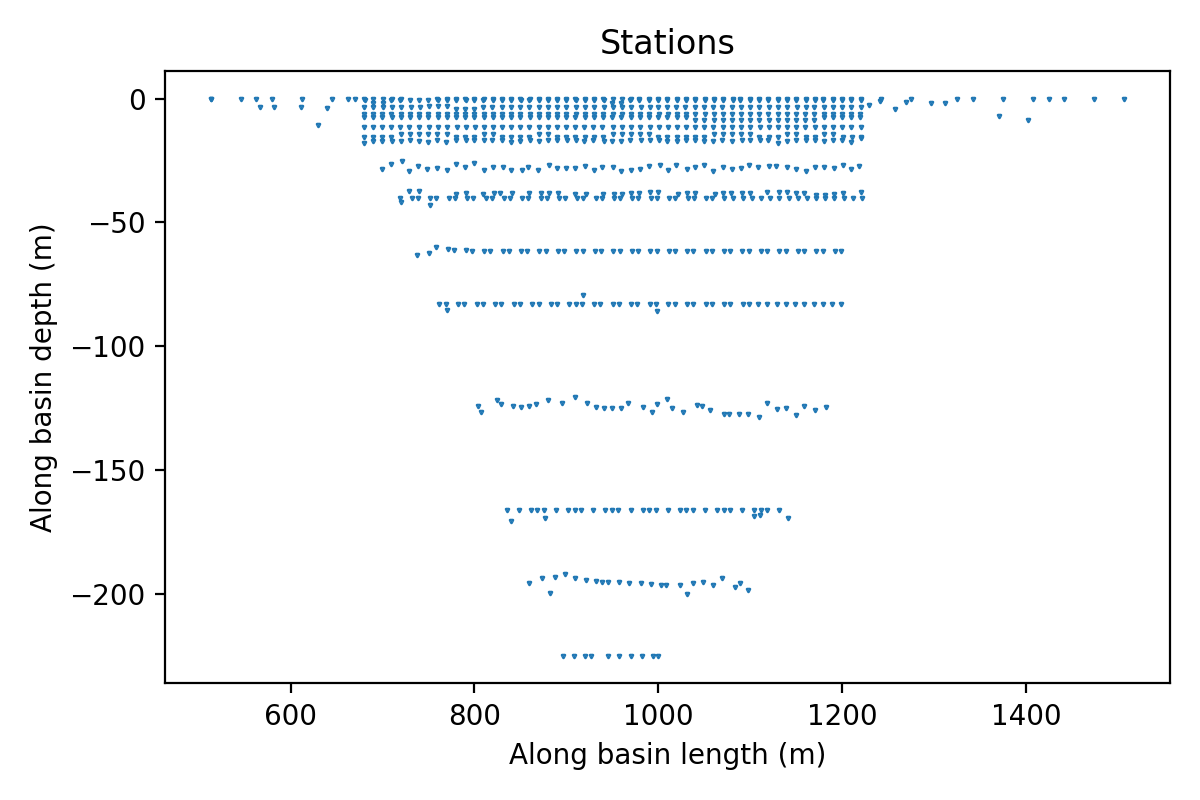

In [5]:
plt.figure(figsize=(6, 4))
plt.scatter(XSTA, ZSTA, s=1, marker='v')
plt.xlabel('Along basin length (m)'); plt.ylabel('Along basin depth (m)')
plt.title('Stations')
plt.tight_layout()

# 5) Plot surface seismograms 

<IPython.core.display.Javascript object>


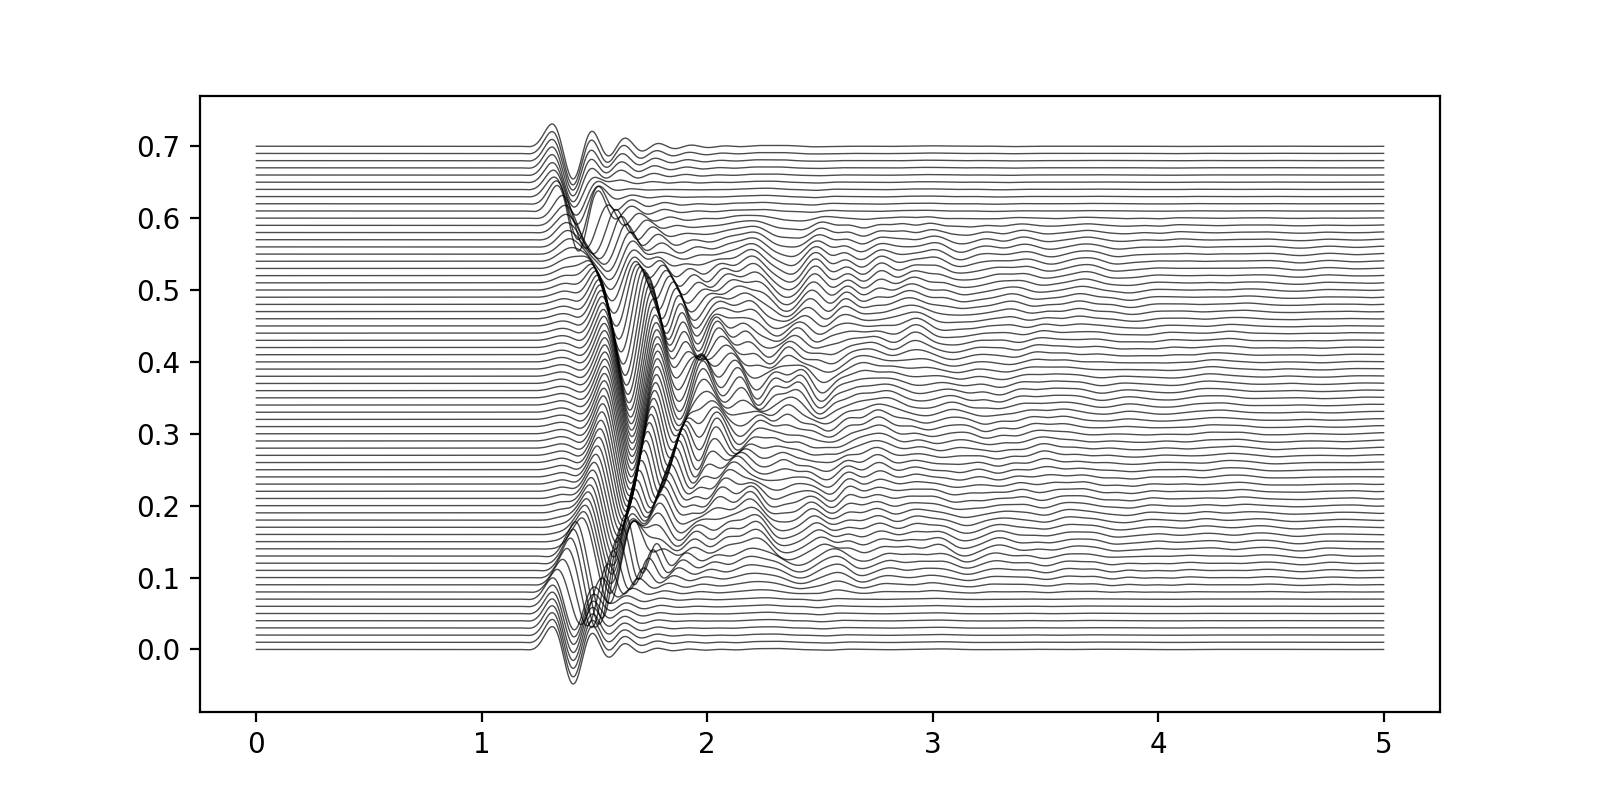

In [6]:
offset=0.01
# cdt: only surface stations
cdt = abs(ZSTA) < 1e-2
V = SEM.velocity[:,cdt]
plt.figure(figsize=(8,4))
for ista in range(0,SEM.rcoord[cdt,0].shape[0]):
    plt.plot(SEM.time, V[:,ista]+ offset*ista, 'k', alpha=0.7, lw=0.5)

# 4) Plot stress-strain curve at a selected location

In [7]:
def get_station_index(SEM, x_chosen=13865.468512, z_chosen=-60.0):
    nsta_extra = SEM.nsta_extra
    x_extra = SEM.extra_coord[:,0]
    z_extra = SEM.extra_coord[:,1]    
    cdt = ( abs(x_extra - x_chosen)+ abs(z_extra-z_chosen)== min(abs(x_extra - x_chosen)+ abs(z_extra-z_chosen)) )
    jj = np.where(cdt)[0]
    for _x, _z in zip(x_extra[jj], z_extra[jj]):
        print ('Found coordinates: ', _x, _z)
    return jj[0]
##

def get_backbone_curve(ii, SEM, rho=0.0, Vs=0.0, overburden_model=True):
    nsta_extra = SEM.nsta_extra
    x_extra = SEM.extra_coord[:,0]
    z_extra = SEM.extra_coord[:,1]
    if not overburden_model: _Gmod = rho* Vs* Vs
    if overburden_model:
            gref = SEM.nonlinear_curve[:,2]
            Gmod = SEM.nonlinear_curve[:,3]     
            x = SEM.nonlinear_curve[:,0]
            z = SEM.nonlinear_curve[:,1]
    #       
    backbone_found = True
    if overburden_model:
        dist = [ (x_extra[ii]- x_node)**2+ (z_extra[ii]- z_node)**2 for x_node, z_node in zip(x, z)]            
        x_nearest = SEM.nonlinear_curve[dist==min(dist), 0] [0]
        z_nearest = SEM.nonlinear_curve[dist==min(dist), 1] [0]   
        _gref = gref[dist==min(dist)][0]
        _Gmod = Gmod[dist==min(dist)][0]

        if len(SEM.nonlinear_curve[dist==min(dist), 0]) == 0:
            backbone_found = False
            print ('Backbone not found!')
    #
    if backbone_found:
        gamma, tau, G_over_G0 = compute_backbone_curve(gref=_gref, mu=_Gmod, Nspr=50)
        gamma *= 1e2; tau /= 1e3 
    ###ax.plot(gamma, tau, -gamma, -tau, c='k',alpha=0.9,linestyle='-', lw=0.5)     
    return gamma, tau
##

In [8]:
%%time 
SEM = sem2dpack(direct1)
SEM.read_nonlinear_backbone_data_tocorrect()
SEM.read_stress_strain() # this may take a while: ~2 min in my laptop
print ('*')

Reading grid information...
Reading header file...
0.00039999999 12501 817
Extra station number:  915
*
*
CPU times: user 1.05 s, sys: 168 ms, total: 1.22 s
Wall time: 1.36 s


<IPython.core.display.Javascript object>


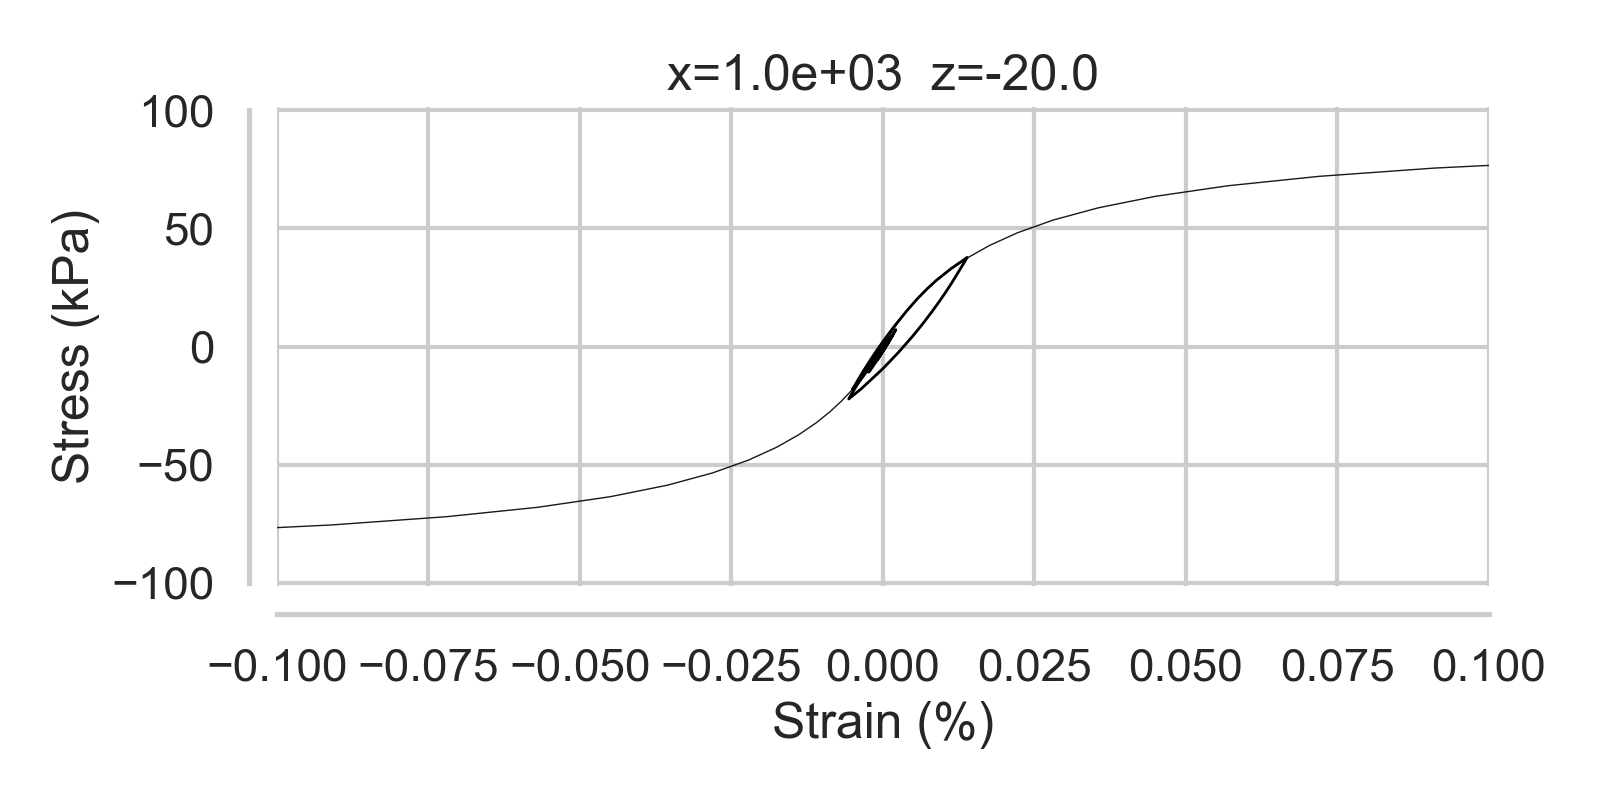

Found coordinates:  999.999997908999 -16.999997195101


In [9]:
### FIGURE ###
plt.close('all')
fig = plt.figure(figsize=(8,4))
set_style(whitegrid=True, scale=1.0)
sns.despine(offset=10, trim=True)

# location 1
xsta, zsta = 1e3, -20.0
ax = plt.subplot(111)
tit = 'x='+ '%.1e' % (xsta)+ '  z='+ '%.1f' % (zsta)
plt.title(tit)
kk = get_station_index(SEM, x_chosen=xsta, z_chosen=zsta)
plt.xlim(-1e-1, 1e-1); 
# plt.ylim(ymin, ymax)
plt.plot(SEM.strain[:,kk]*1e2, SEM.stress[:,kk]/1e3, c='k',lw=1)
gamma, tau = get_backbone_curve(kk, SEM, overburden_model=is_overburden)
plt.plot(gamma, tau, -gamma, -tau, c='k',alpha=0.9,linestyle='-', lw=0.5)
plt.xlabel('Strain (%)'); plt.ylabel('Stress (kPa)')


sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.show()
#

In [ ]:
#fin